In [1]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import datetime
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from matplotlib import pyplot as plt
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers import Masking
from tqdm import tqdm_notebook
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 673194290245745449
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6700998385222685573
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6685550442572346285
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5811535872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7956821867374047407
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:65:00.0, compute capability: 7.5"
]


In [4]:
from keras import backend as K

K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### data 불러오기

In [5]:
Y_가전제품 = pd.read_csv('Y_가전제품.csv')
Y_화장품 = pd.read_csv('Y_화장품.csv')
Y_패션 = pd.read_csv('Y_패션.csv')

In [6]:
Y_가전제품= Y_가전제품['가전제품구매']
Y_화장품= Y_화장품['화장품구매']
Y_패션= Y_패션['패션구매']

In [7]:
X_가전제품 = pd.read_csv('가전제품_3d_array.csv')
X_화장품 = pd.read_csv('화장품_3d_array.csv')
X_패션 = pd.read_csv('패션_3d_array.csv')

In [8]:
X_가전제품.head()

,0,1,2,3,4,5,6,7,8,9,...,94990,94991,94992,94993,94994,94995,94996,94997,94998,94999
0,1754,29010,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,308,10185,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,24,314,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1302,29956,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1361,7985,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [9]:
X_가전제품 = np.asarray(X_가전제품)
X_화장품 = np.asarray(X_화장품)
X_패션 = np.asarray(X_패션)

### Oversampling

In [10]:
X_가전제품.shape

(1063, 95000)

In [11]:
smote = SMOTE()

In [12]:
#5000일때 자꾸 커널이 죽음
def oversample(X, Y):
    max_len = 5000
    X_resampled, Y_resampled = smote.fit_resample(X, Y)
    X_resampled = X_resampled.reshape(X_resampled.shape[0], max_len, int(X_resampled.shape[1]/max_len))
    return X_resampled, Y_resampled

In [13]:
X_가전제품_resampled, Y_가전제품_resampled =oversample(X_가전제품, Y_가전제품)
X_패션_resampled, Y_패션_resampled = oversample(X_패션, Y_패션)
X_화장품_resampled, Y_화장품_resampled = oversample(X_화장품, Y_화장품)

### LSTM 가동

In [14]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### 패션

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
X_패션_resampled, Y_패션_resampled, test_size=0.3, random_state=42)

In [16]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [17]:
X_train.shape

(1606, 5000, 19)

In [18]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation= 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
print(model.summary())

W0120 15:56:23.525620 140037974812480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 5000, 19)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                21504     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 24,163
Trainable params: 24,163
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
history = model.fit(X_train, y_train, epochs=30, batch_size=100, validation_data=(X_test, y_test), verbose=2, shuffle=False)

W0120 15:56:25.005447 140037974812480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 1606 samples, validate on 689 samples
Epoch 1/30
 - 98s - loss: 1.0741 - acc: 0.4166 - val_loss: 1.0368 - val_acc: 0.5254
Epoch 2/30
 - 98s - loss: 1.0148 - acc: 0.5430 - val_loss: 0.9806 - val_acc: 0.5544
Epoch 3/30
 - 98s - loss: 0.9538 - acc: 0.5560 - val_loss: 0.9207 - val_acc: 0.5472
Epoch 4/30
 - 98s - loss: 0.9106 - acc: 0.5585 - val_loss: 0.8915 - val_acc: 0.5443
Epoch 5/30
 - 98s - loss: 0.8750 - acc: 0.5716 - val_loss: 0.8587 - val_acc: 0.5660
Epoch 6/30
 - 98s - loss: 0.8497 - acc: 0.5909 - val_loss: 0.8367 - val_acc: 0.5951
Epoch 7/30
 - 98s - loss: 0.8354 - acc: 0.5978 - val_loss: 0.8297 - val_acc: 0.5980
Epoch 8/30
 - 98s - loss: 0.8230 - acc: 0.6052 - val_loss: 0.8188 - val_acc: 0.6154
Epoch 9/30
 - 98s - loss: 0.8102 - acc: 0.6146 - val_loss: 0.8236 - val_acc: 0.6125
Epoch 10/30
 - 98s - loss: 0.8047 - acc: 0.6096 - val_loss: 0.8084 - val_acc: 0.6168
Epoch 11/30
 - 99s - loss: 0.7946 - acc: 0.6208 - val_loss: 0.8295 - val_acc: 0.6096
Epoch 12/30
 - 98s - loss: 

In [20]:
#perm = PermutationImportance(model, random_state=1).fit(X_test,y_test)
#eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [21]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

In [22]:
#가전제품 f1-score: 0.7819220343082984
#패션 accuracy: 0.7188029361269287

print(accuracy)

0.6153846383094788


#### 가전제품

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
X_가전제품_resampled, Y_가전제품_resampled, test_size=0.3, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [24]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation= 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 5000, 19)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                21504     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 51        
Total params: 24,163
Trainable params: 24,163
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
history = model.fit(X_train, y_train, epochs=30, batch_size=500, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 1946 samples, validate on 835 samples
Epoch 1/30
 - 30s - loss: 1.0938 - acc: 0.3510 - val_loss: 1.0553 - val_acc: 0.4311
Epoch 2/30
 - 29s - loss: 1.0380 - acc: 0.4959 - val_loss: 1.0181 - val_acc: 0.5102
Epoch 3/30
 - 28s - loss: 0.9959 - acc: 0.5591 - val_loss: 0.9789 - val_acc: 0.5269
Epoch 4/30
 - 29s - loss: 0.9479 - acc: 0.5910 - val_loss: 0.9385 - val_acc: 0.5353
Epoch 5/30
 - 29s - loss: 0.8881 - acc: 0.6048 - val_loss: 0.8840 - val_acc: 0.5653
Epoch 6/30
 - 29s - loss: 0.8390 - acc: 0.6238 - val_loss: 0.8510 - val_acc: 0.5713
Epoch 7/30
 - 29s - loss: 0.8076 - acc: 0.6429 - val_loss: 0.8196 - val_acc: 0.5988
Epoch 8/30
 - 29s - loss: 0.7747 - acc: 0.6588 - val_loss: 0.7935 - val_acc: 0.6132
Epoch 9/30
 - 30s - loss: 0.7495 - acc: 0.6706 - val_loss: 0.7859 - val_acc: 0.6048
Epoch 10/30
 - 29s - loss: 0.7486 - acc: 0.6511 - val_loss: 0.7672 - val_acc: 0.6144
Epoch 11/30
 - 29s - loss: 0.7181 - acc: 0.6727 - val_loss: 0.7497 - val_acc: 0.6395
Epoch 12/30
 - 29s - loss: 

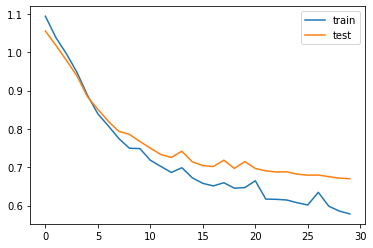

In [26]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()                                       
plt.show()                       

In [27]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

In [28]:
#가전제품 f1-score: 0.7819220343082984

print(accuracy)

0.7197604775428772


#### 화장품

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
X_화장품_resampled, Y_화장품_resampled, test_size=0.3, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [30]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 5000, 19)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                21504     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 51        
Total params: 24,163
Trainable params: 24,163
Non-trainable params: 0
__________________________________________________

In [31]:
history = model.fit(X_train, y_train, epochs=50, batch_size=500, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 1732 samples, validate on 743 samples
Epoch 1/50
 - 27s - loss: 1.1026 - acc: 0.3458 - val_loss: 1.0818 - val_acc: 0.4576
Epoch 2/50
 - 27s - loss: 1.0733 - acc: 0.4353 - val_loss: 1.0429 - val_acc: 0.5316
Epoch 3/50
 - 27s - loss: 1.0409 - acc: 0.4925 - val_loss: 1.0125 - val_acc: 0.5532
Epoch 4/50
 - 27s - loss: 1.0158 - acc: 0.5300 - val_loss: 0.9910 - val_acc: 0.5505
Epoch 5/50
 - 26s - loss: 0.9908 - acc: 0.5543 - val_loss: 0.9674 - val_acc: 0.5734
Epoch 6/50
 - 27s - loss: 0.9755 - acc: 0.5554 - val_loss: 0.9484 - val_acc: 0.5774
Epoch 7/50
 - 27s - loss: 0.9510 - acc: 0.5716 - val_loss: 0.9300 - val_acc: 0.5841
Epoch 8/50
 - 27s - loss: 0.9399 - acc: 0.5779 - val_loss: 0.9183 - val_acc: 0.5908
Epoch 9/50
 - 26s - loss: 0.9288 - acc: 0.5889 - val_loss: 0.8980 - val_acc: 0.5949
Epoch 10/50
 - 27s - loss: 0.9128 - acc: 0.5930 - val_loss: 0.8819 - val_acc: 0.6137
Epoch 11/50
 - 27s - loss: 0.8934 - acc: 0.5872 - val_loss: 0.8783 - val_acc: 0.6178
Epoch 12/50
 - 27s - loss: 